In [1]:
import pandas as pd
import numpy as np
import geopandas as geopd

import shapely
from shapely import Polygon

import rasterio
from rasterio import features

from graph_utils import *

import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 20)

plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

# Plan
- read the river network

- Read all the waterhseds and combine them to one geopackage
- Does the geometry need fixing e.g. if a pixel touches on the corner?
- Using spatial index, clip the network
- Test the clipped network
    - There should only be one intersection point with the boundary. Edge artifacts are possible, but hopefully rare. They could be tested/accounted for by using a catchment buffered by < 50m. If the problem persists, the dem might be wrong and the case should be handled with a human in the loop
    - there should be only one pour point (at the one intersection), meaning that there is only one network. Momepy has tools that could help.
    - Bifurcation removals can create small unconnected bits, they should be removed (Create network for both pour points, remove very small).
    - network should be tested for remaining bifurcations (loops)
- The pour points of the corresponding watersheds should be snapped to the pour point, and saved as one layer.
- save the networks as layers in a geopackage


In [3]:
#networks = geopd.read_file("/home/iiro/Documents/DIWA/data/SYKE/uomaverkosto/Uoma10.shp")
#gauge_path = "/home/iielse/Documents/DIWA/data/omat digitoinnit/CAMELS-FI flow gauges.gpkg"
#gauges = geopd.read_file(gauge_path, layer="v1")

# for bea
# For bea
gauge_path = "/home/iielse/Documents/DIWA/bea/aurajoki_nutrients.gpkg"
gauges = geopd.read_file(gauge_path, layer="locations")

# Remove the side connections (bifurcations) marked out in the data
#networks = networks.loc[networks['paareitti'] != 'Sivuvirtausreitin ensimmäinen uoma']

In [4]:
watershed_root = "/media/iielse/T9/gisT7/korkeusmalli_10_m/watershed"

watersheds = geopd.GeoDataFrame(columns=['Paikka_Id', 'geometry'], crs=gauges.crs, geometry='geometry')
pbar = tqdm(gauges.iterrows(), total=len(gauges))
for i, gauge in pbar:
    # Changing from series to dataframe
    gauge = geopd.GeoDataFrame(
                    dict(zip(list(gauge.index), list(gauge.values))),
                    crs=gauges.crs, geometry='geometry', index=[0])

    place_id = gauge.at[0, 'Paikka_Id']
    watershed_path = os.path.join(watershed_root, place_id, "full", f"watershed_{place_id}.tif")
    # Checking that the path exists
    assert os.path.isfile(watershed_path), f"Path {watershed_path} doesn't exist"

    with rasterio.open(watershed_path, 'r') as src:
        # Using 8 connectiivity, should be tested to see if it causes problems
        shapes = features.shapes(rasterio.band(src, 1), mask=src.read_masks(1), connectivity=8)

        polys = list(shapes)
        geoms = [shapely.geometry.shape(i[0]) for i in polys]

        #if len(geoms) == 1:
            #geom = geoms[0]
        largest = 0
        largest_idx = 0
        for i, part in enumerate(geoms):
            
            if part.area > largest:
                largest = part.area
                largest_idx = i

        # choose the biggest of the geometries
        #geom = geopd.GeoSeries(geom, crs=src.crs)
    # Adding a row to the end
    watersheds.loc[len(watersheds.index)] = [place_id, geoms[largest_idx]]

        
watersheds = watersheds.set_crs(crs=gauges.crs)

  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

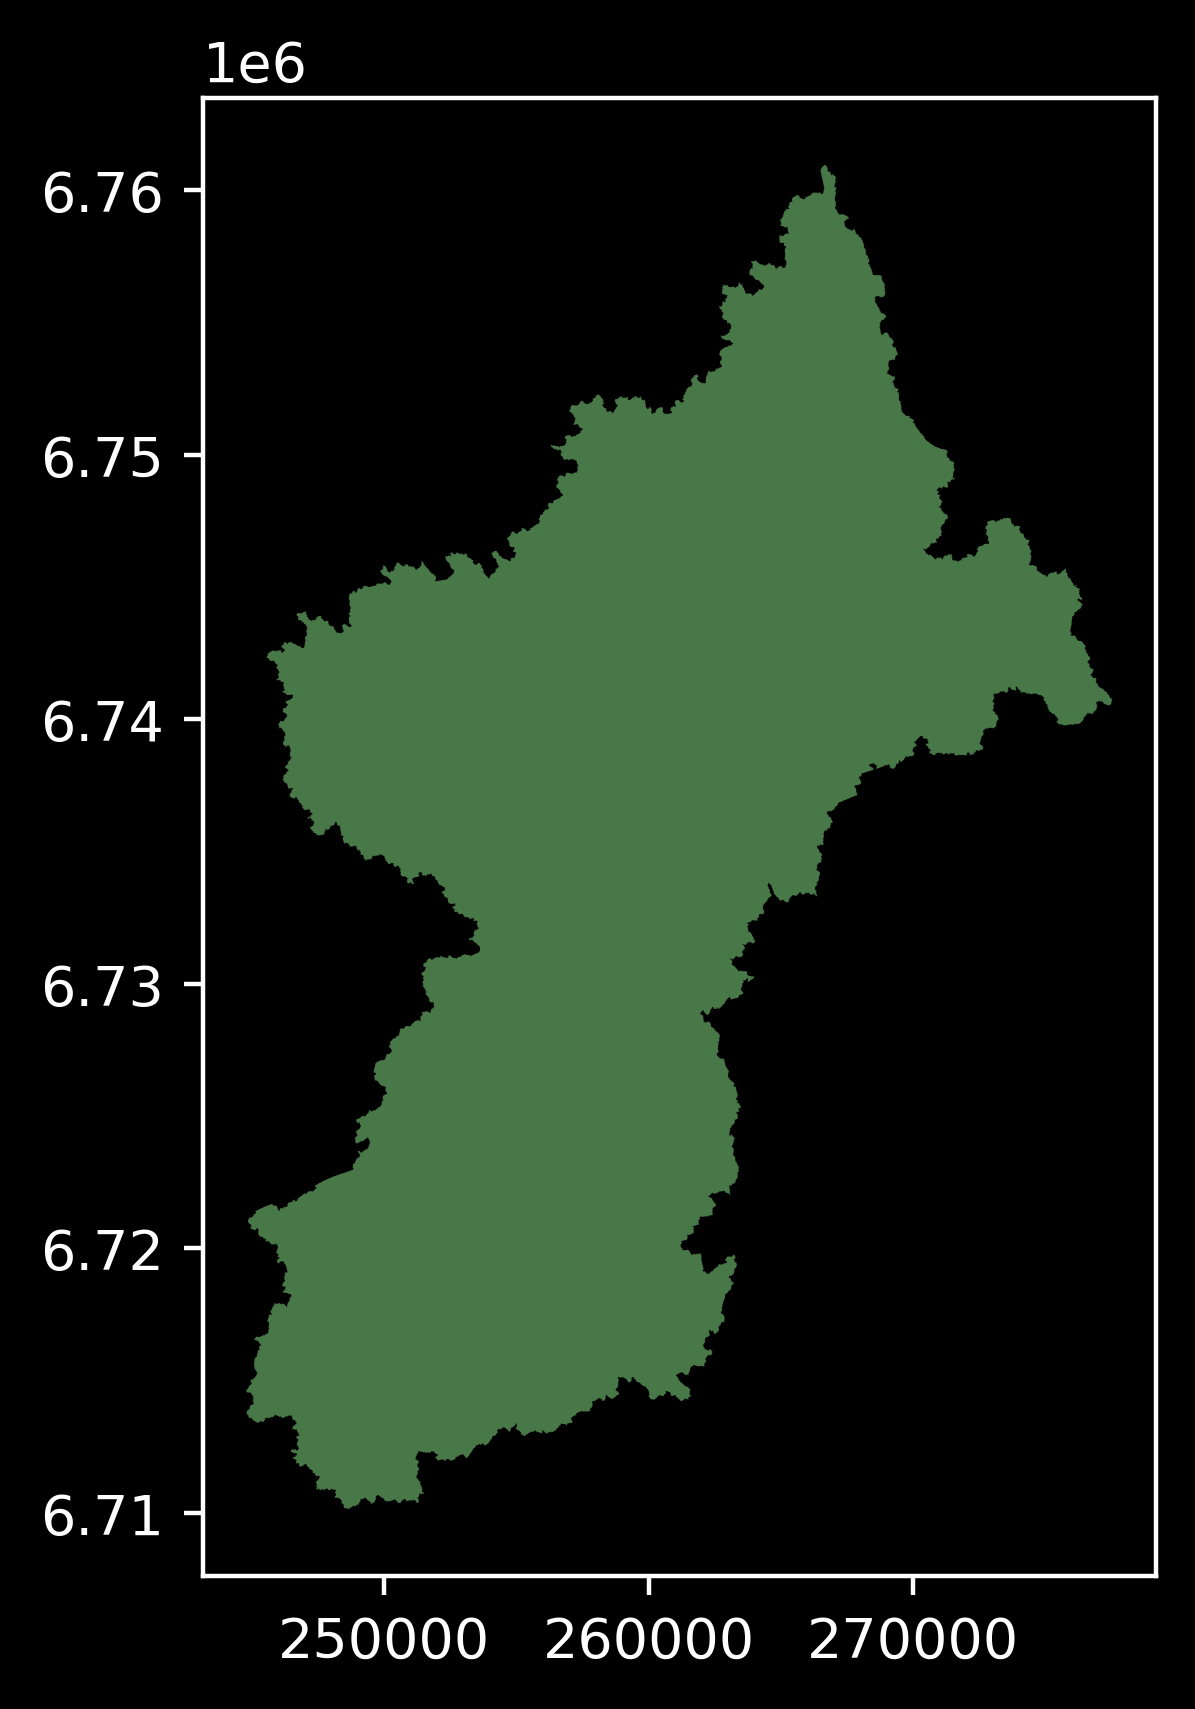

In [5]:
watersheds.plot(alpha=0.5, color='lightgreen')

In [6]:
watersheds['area'] = watersheds.area

watersheds.loc[watersheds['area'] < 1_000_000]

,Paikka_Id,geometry,area


In [7]:
watersheds.to_file("CAMELS-FI catchments/CAMELS-FI_catchments.gpkg", driver="GPKG", layer='v1')

# TODO 
- siirä tieto päävesistöalueesta valuma-alueille

In [7]:
main_basins_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_basins.gpkg"
main_basins = geopd.read_file(main_basins_path, layer='v1')
# Getting the index as a new column
main_basins = main_basins.reset_index()
main_basins = main_basins[['index', 'geometry']]
main_basins

,index,geometry
0,0,"MULTIPOLYGON (((355970 7604120, 355970 7604150..."
1,1,"MULTIPOLYGON (((372920 7005570, 372950 7005570..."
2,2,"MULTIPOLYGON (((217260 6834180, 217270 6834180..."
3,3,"MULTIPOLYGON (((434070 7198220, 434070 7198230..."
4,4,"MULTIPOLYGON (((419780 7580780, 419780 7580790..."
...,...,...
69,69,"MULTIPOLYGON (((457790 6706670, 457800 6706670..."
70,70,"MULTIPOLYGON (((262860 7651950, 262860 7651960..."
71,71,"MULTIPOLYGON (((504220 6997730, 504230 6997730..."
72,72,"MULTIPOLYGON (((533170 6988870, 533180 6988870..."


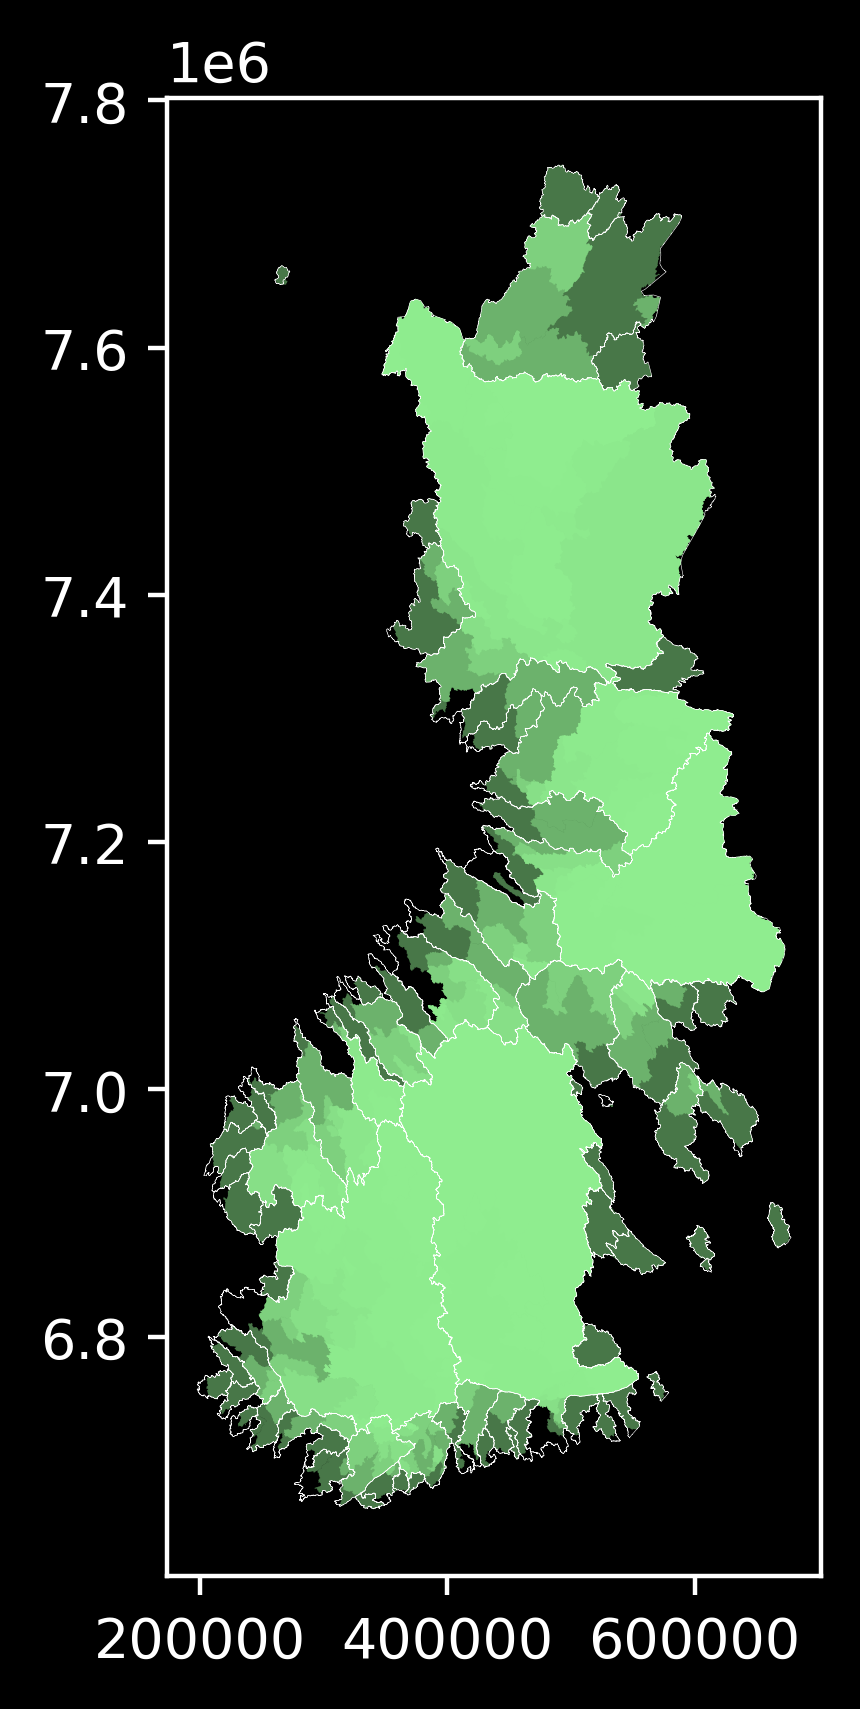

In [8]:
ax = watersheds.plot(alpha=0.5, color='lightgreen')
ax = main_basins.boundary.plot(ax=ax, color='white', linewidth=0.1)

In [9]:
new_watersheds = geopd.GeoDataFrame(columns=['Paikka_Id', 'main_basin_index', 'geometry'], crs=watersheds.crs, geometry='geometry')

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    
    watershed = geopd.overlay(watershed, main_basins, how='intersection', keep_geom_type=True)
    watershed['area_m2'] = watershed.area
    if len(watershed) > 1:
        watershed = watershed.sort_values(by='area_m2', ascending=False)
        #watershed = watershed.drop_duplicates(keep='last')
        
    watershed = watershed.reset_index(drop=True)
    
    new_watersheds.loc[len(new_watersheds.index)] = [watershed.at[0, 'Paikka_Id'], watershed.at[0, 'index'], watershed.at[0, 'geometry']]

new_watersheds = new_watersheds.set_crs(crs=watersheds.crs)

watersheds = new_watersheds  

  0%|          | 0/331 [00:00<?, ?it/s]

In [10]:
vector_watershed_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_watersheds.gpkg"

watersheds.to_file(vector_watershed_path, driver="GPKG", layer='v1')

# Network clipping and topology fixing

In [10]:
river_network_path = "/home/iiro/Documents/DIWA/data/omat digitoinnit/uoma10_no_bifurcation.gpkg" 

vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

In [40]:
""" All the results are saved to a geopackage with the following naming convention for layers:
Pour points: f"pour_{place_id}"
Network: f"network_{place_id}"
Nodes: f"nodes_{place_id}"
"""
test_selection = 146

dst_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/network.gpkg"

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    # Getting the gauge that corresponds to the watershed
    place_id = watershed.at[0, 'Paikka_Id']
    gauge = gauges.loc[gauges['Paikka_Id'] == place_id].reset_index(drop=True)

    # There might be some spots that only corner the watershed and are the size of one pixel (10m), they are removed.
    boundary = watershed.boundary.explode().reset_index()
    watershed = watershed.explode().reset_index()
    boundary['length'] = boundary.length
    # Set experimentally
    watershed = watershed.loc[boundary['length'] > 200]
    # Getting the west, south, east and north bounds
    bounds = watershed.bounds
    bounds = bounds.reset_index(drop=True)
    minx = bounds.at[0, 'minx']
    miny = bounds.at[0, 'miny']
    maxx = bounds.at[0, 'maxx']
    maxy = bounds.at[0, 'maxy']

    # Reading the watercourses from the area of the watershed
    river_network = geopd.read_file(river_network_path, bbox=(minx, miny, maxx, maxy))

    # Clipping to the watershed
    river_network = river_network.clip(watershed, keep_geom_type=True)

    # Changing from MultiLine to LineString 
    river_network = river_network.explode(ignore_index=True)
    # Topology check 
    result = check_network_topology(river_network)
    #print(result)
    if not result['is_simple']:
        print(f"graph of watershed {i} is not simple")
    #if not result['has_one_pour']:
        
        
    # Form networks based on all of the pour point
    nodes = get_start_and_end_nodes(river_network)
   
    # Most watersheds are fine with tolerance of 5m 
    pour = get_pour(nodes)
    """pour point should be next to the boundary, 
    so if pour point is far from the boundary,
    it should be merged to the larger network
    """
    #assert len(pour) !=0
    #print(f"Pour {place_id} before boundary clipping {len(pour)}")

    # Checking the distance to the actual pour point and removing too far being points
    pour = pour.assign(distance=lambda row: row.distance(gauge.at[0, 'geometry']))
    pour = pour.loc[pour['distance'] < 400]
    
    assert len(pour) != 0, f"Gauge {place_id} is too far from closet pour"
        

    #print(f"Pour {place_id} after boundary clipping {len(pour)}")
    #print("-" * 10)
    
    # The network is traversed in order to determine the correct pour point and sufficient netowrk coverage
    long_visited = []
    potential_pours = []
    for j, pour_j in pour.iterrows():
        # Changing from 
        pour_j = geopd.GeoDataFrame(
            dict(zip(list(pour_j.index), list(pour_j.values))),
            crs=pour.crs, geometry='geometry', index=[0])
        
        pour_j_connections = add_connections(nodes, pour_j)
        #print(len(pour_j_connections))
        visited = traverse_graph(pour_j_connections, pour_j.at[0, 'id'])
        
        #print(len(visited))
        # small offshoot branches are skipped, Pesiö's watersheds are special becuse they are so tiny
        pesiö_ids = ['2641', '2643', '2646']
        
        if len(visited) > 2 or place_id in pesiö_ids:
            coverage = round((len(visited) / len(pour_j_connections) *100), 1)
            if coverage < 95:
                print(f"{coverage} % of nodes visited for gauge {place_id}, watershed  {i}")    
            long_visited.append(visited)
            potential_pours.append(pour_j)
            
    assert len(long_visited) <= 1, f"multiple pour points remain for {place_id}"    
        
    assert len(long_visited) != 0, f"Gauge {place_id} doesn't have a long network"

    # There should be only one pour left based on the asserts above 
    pour = potential_pours[0]

    pour.to_file(dst_path, driver="GPKG", layer=f"pour_{place_id}")

    # Only the nodes visited in the longest path are retained
    real_nodes = nodes.loc[nodes.index.isin(long_visited[0])]

    real_nodes.to_file(dst_path, driver="GPKG", layer=f"nodes_{place_id}")
    
    # Select the network parts that touch the pour points
    real_network = geopd.sjoin(river_network, real_nodes, how='inner').drop_duplicates()
    real_network.to_file(dst_path, driver="GPKG", layer=f"network_{place_id}")
    
    
        # if there are two large enough networks, they should be merged with momepy tools
        
        # If there is a pour point at the boundary, and the network is small, it should be tried to be merged with sources that are very close (~<30 m)
            # otherwise it should be deleted.
    #if i == test_selection:
        #break  

  0%|          | 0/167 [00:00<?, ?it/s]

In [37]:
pour

,geometry,id,pituus_m,distance


In [39]:
get_pour(nodes, tolerance=5)

,geometry,id,pituus_m


In [25]:
watershed

,index,Paikka_Id,main_basin_index,geometry
0,0,987,102,"POLYGON ((381210 7007980, 381230 7007980, 3812..."


/tmp/ipykernel_32806/2261663682.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = pour.plot(color='coral', ax=ax, markersize=0.3)


(461611.5, 481378.5, 6809742.0, 6830378.0)

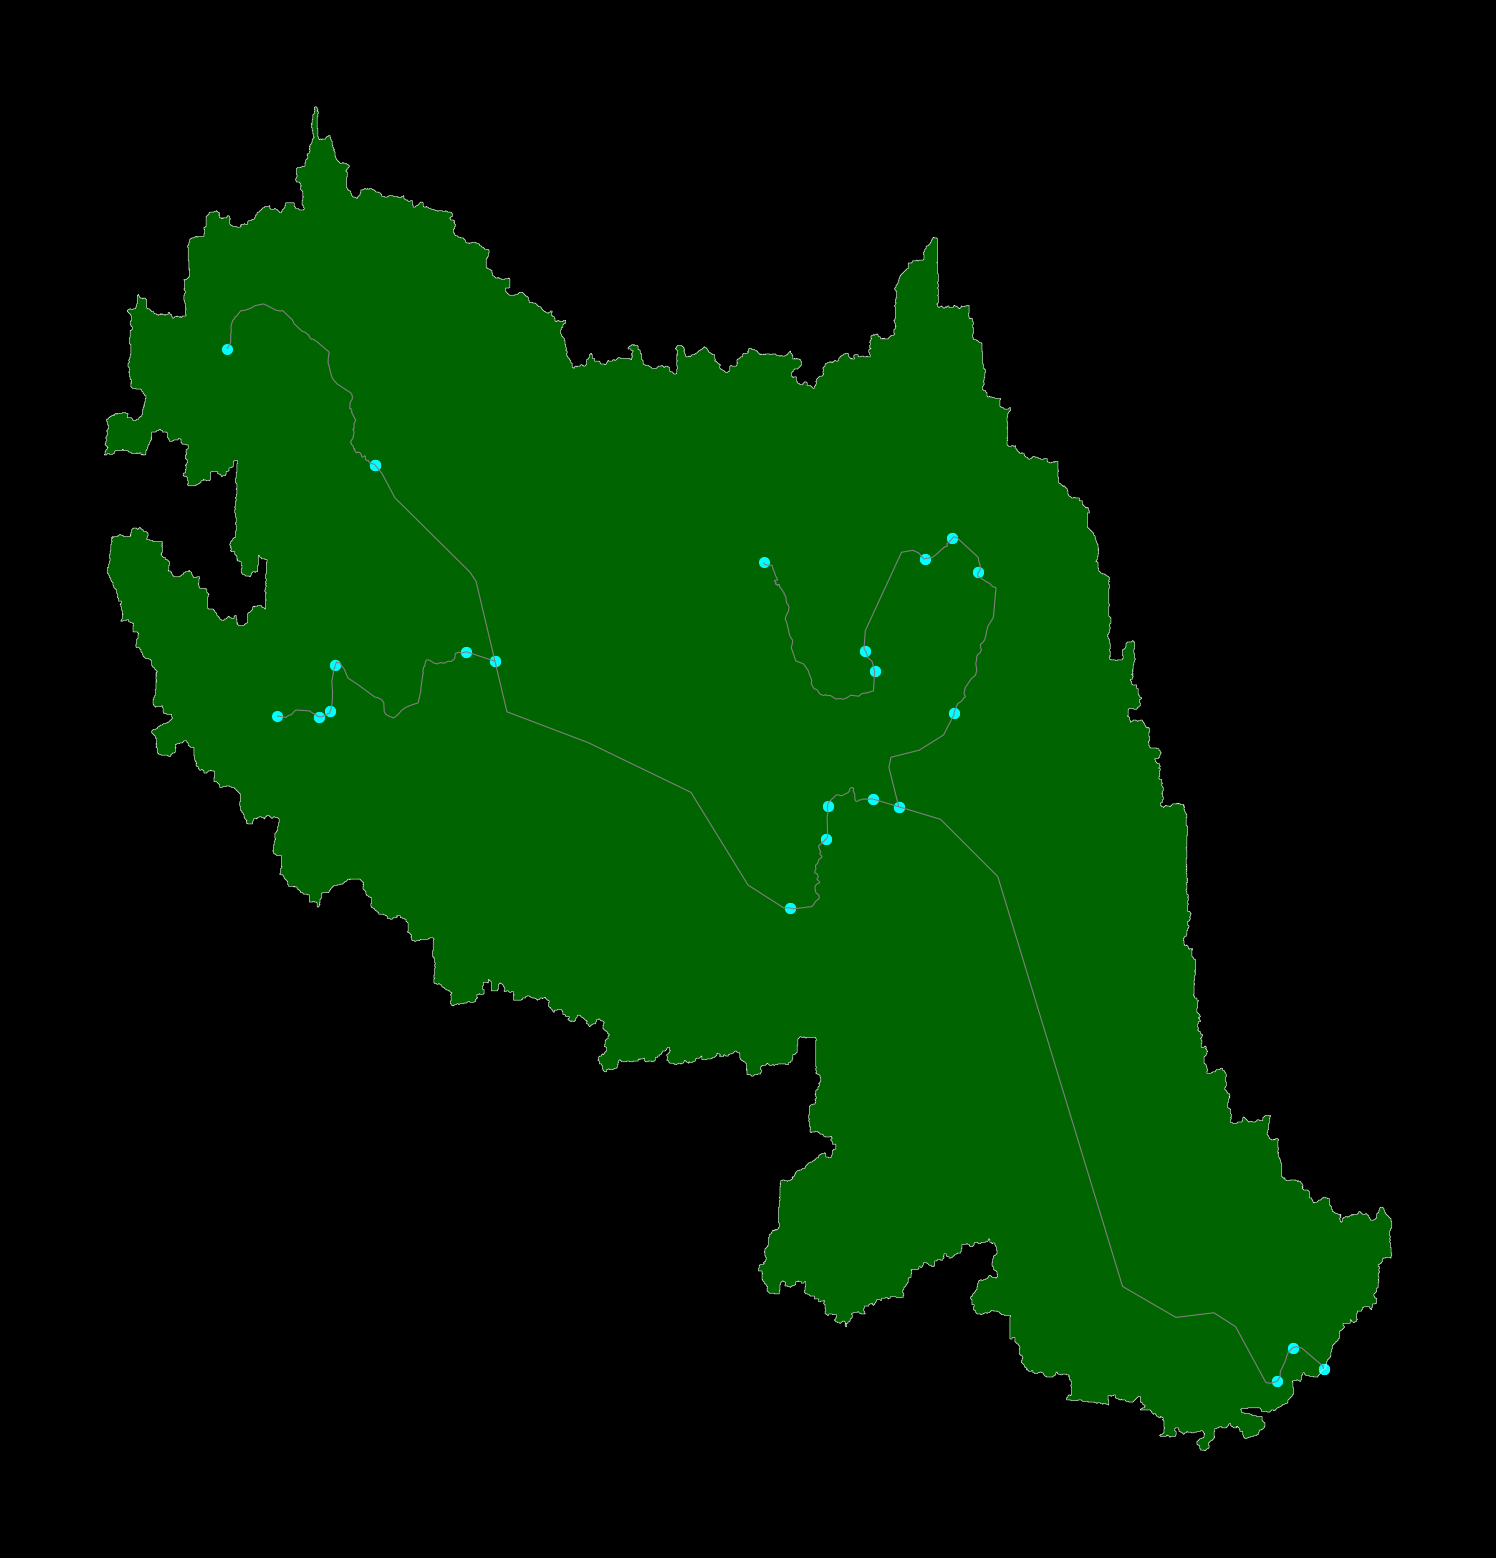

In [36]:
ax = watershed.plot(color='darkgreen')
ax = watershed.boundary.plot(ax=ax, color='white', linewidth=0.1)
ax = river_network.plot(ax=ax, color='grey', linewidth=0.2)
#ax = real_network.plot(ax=ax, color='aqua', linewidth=0.4)
#ax = pour_j_connections.plot(ax=ax, markersize=0.5, color='yellow') 
#ax = real_nodes.plot(ax=ax, markersize=5, color='orange')
ax = nodes.plot(ax=ax, markersize=1, color='aqua')

#ax = gauge.plot(ax=ax, color='purple', markersize=3)
ax = pour.plot(color='coral', ax=ax, markersize=0.3)

plt.axis('off')
#plt.ylim(7_280_680, 7_290_000)
#plt.xlim(405_220.0, 420_000.0)

### TODO check if boundary is intersecting with a source to check for possible missing areas

In [21]:
boundary = watershed.boundary.explode().reset_index()
boundary['length'] = boundary.length
boundary = boundary.loc[boundary['length'] > 160]
boundary = boundary.rename({0:'geometry'}, axis=1)
boundary = boundary.set_geometry('geometry', crs=watersheds.crs)

network = geopd.read_file(river_network_path, bbox=(minx, miny, maxx, maxy))
intersection = geopd.overlay(boundary, network, keep_geom_type=False)

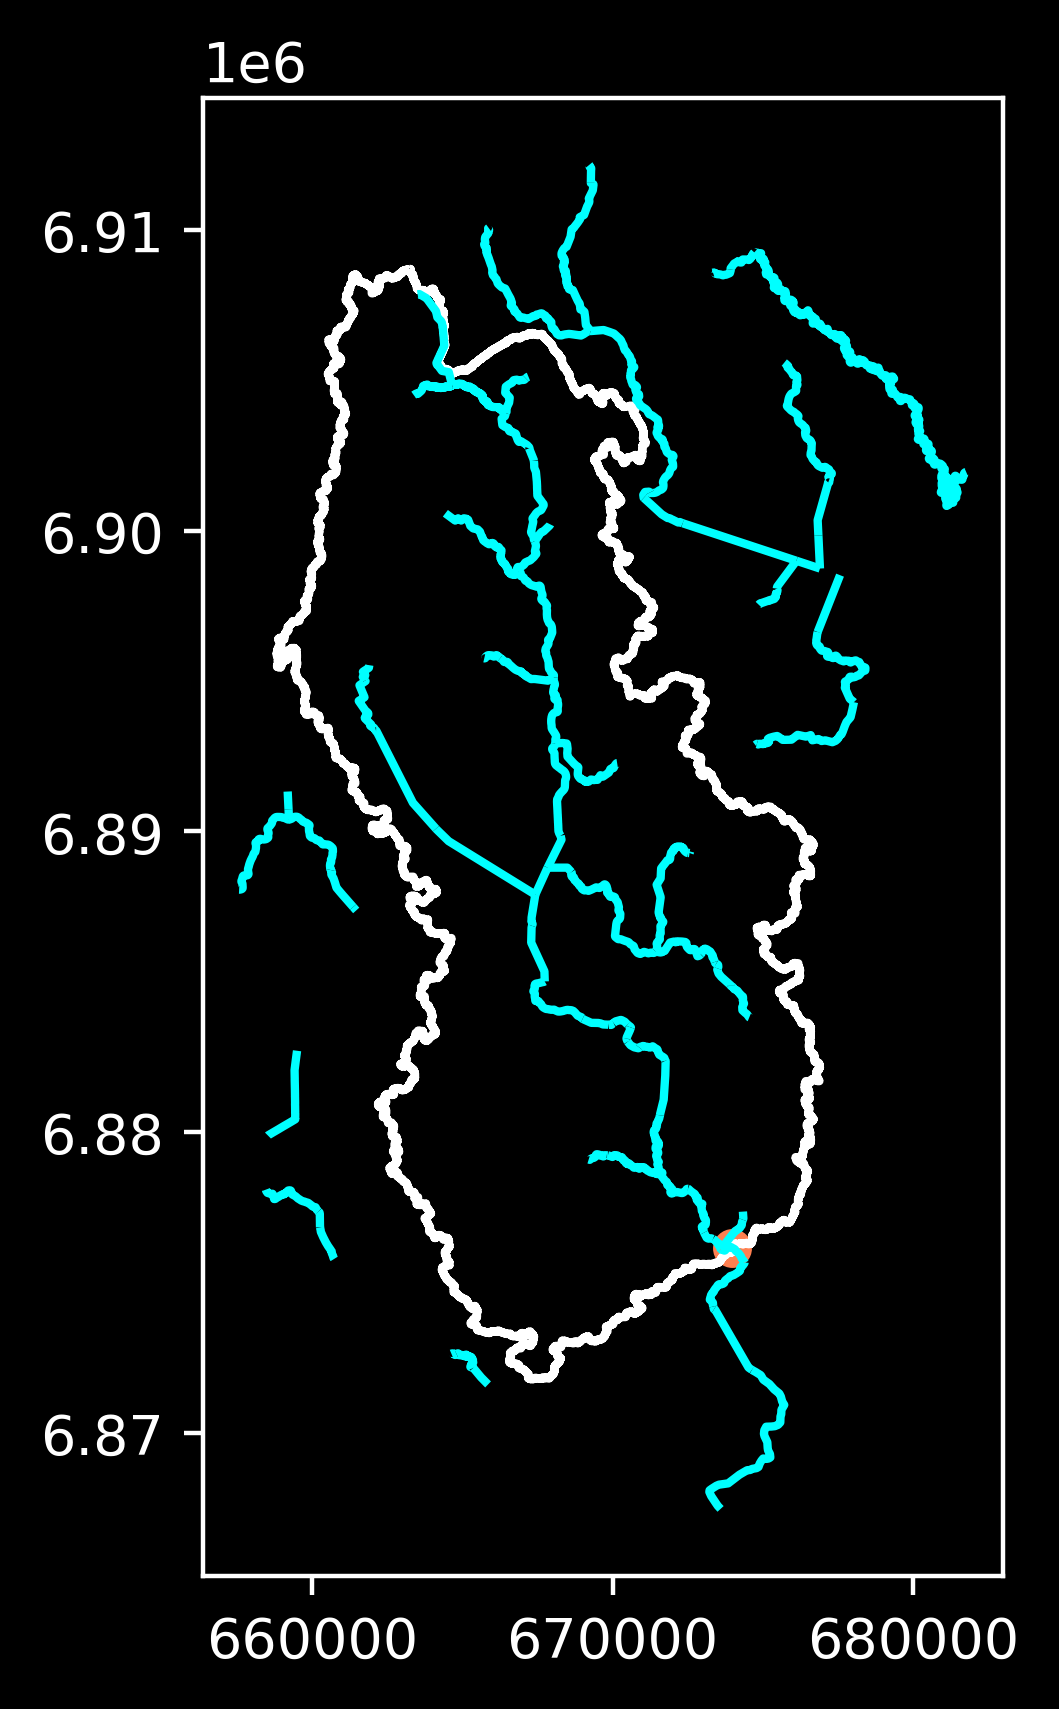

In [23]:
ax = boundary.plot()
ax = network.plot(ax=ax, color='aqua')
ax = intersection.plot(ax=ax, color='coral') 

In [26]:
intersection

,index,length,objectid,uomanro,muutospvm,uomaluokka,paareitti,pituus_m,pituusalle,pituusyli5,uomapistei,uomapist00,rannikkove,valuyla_pa,valumaalue,paavesisto,vhatunnus,valtio,geometry
0,0,200880.0,22499,1.007082e+12,20211116000000,joki tai jokipseudo,Päävirtausreittiin kuuluva uoma,3194.38,0.0,3194.38,5000489,5000492,None,NaN,None,2,VHA1,FIRU,POINT (673970 6876152.864)


In [3]:
watersheds = geopd.GeoDataFrame(columns=['paikka_id', 'geometry'], crs=gauges.crs, geometry='geometry')

In [7]:
watersheds

,Paikka_Id,area,geometry
0,896,375491200.0,"POLYGON ((663340 6908160, 663340 6908150, 6633..."
1,900,784838700.0,"POLYGON ((635400 7091780, 635400 7091770, 6353..."
2,905,699014200.0,"POLYGON ((610660 7089910, 610660 7089900, 6106..."
3,907,413585800.0,"POLYGON ((578910 7089310, 578910 7089300, 5789..."
4,930,243997500.0,"POLYGON ((482360 7088740, 482360 7088700, 4823..."
...,...,...,...
138,3975,472356700.0,"POLYGON ((549420 6761930, 549420 6761920, 5494..."
139,1272,102434900.0,"POLYGON ((579110 7212010, 579110 7211990, 5791..."
140,938,79651600.0,"POLYGON ((501780 7008120, 501780 7008110, 5017..."
141,6471,303270900.0,"POLYGON ((356460 7028250, 356460 7028230, 3564..."


In [10]:
gauges

,Paikka_Id,Suure_Id,H_Kunta_Id,KuntaNimi,Nro,Nimi,KoordYkPohj,KoordYkIta,KoordPkPohj,KoordPkIta,...,VesalNimi,H_PaaVesal_Id,PaaVesalNimi,KoordErTmPohj,KoordErTmIta,Jarvi_Id,JarviNro,JarviNimi,testi,geometry
0,896,2,260,Kitee,0201000,Kontturi,6879031,3674209,6874612,4516944,...,Kiteenjoen alaosan a,2,Tohmajoki,6876149,673968,742,02.021.1.001,Kamarahkonlampi,1,POINT (673968 6876149)
1,900,2,422,Lieksa,0400520,"Jongunjoki, Viitakoski",7054821,3649961,7051283,4500910,...,Jongunjoen a,4,Vuoksi,7051867,649728,None,None,None,1,POINT (649728 7051867)
2,905,2,541,Nurmes,0401110,"Saramojoki, Roukkajankoski",7062005,3603895,7060617,4455241,...,Roukkajankosken a,4,Vuoksi,7059048,603681,7860,04.471.1.001,Ylikylänjärvi,0,POINT (603681 7059048)
3,907,2,541,Nurmes,0401320,"Valtimonjoki, Nuolikoski",7068677,3587060,7068071,4438739,...,Nuolijärven a,4,Vuoksi,7065717,586853,None,None,None,1,POINT (586853 7065717)
4,930,2,263,Kiuruvesi,0405440,Luupujoki,7064565,3491017,7064565,3491017,...,Luupuveden a,4,Vuoksi,7061606,490849,None,None,None,1,POINT (490849 7061606)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,3975,2,489,Miehikkälä,0912000,"Urpalanjoki, Tohmonsilta",6727728,3549394,6727728,3549394,...,Urpalanjoen alaosan a,9,Urpalanjoki,6724906,549205,None,None,None,0,POINT (549205 6724906)
139,1272,2,777,Suomussalmi,5900180,Pesiöjärvi - luusua,7205067,3582843,7204502,4440960,...,Pesiöjärven la,59,Oulujoki,7202052,582637,27907,59.541.1.001,Pesiöjärvi,0,POINT (582637 7202052)
140,938,2,297,Kuopio,0406610,Pulkonkoski,7002919,3509000,7002919,3509000,...,Ala-Pulkon va,4,Vuoksi,6999985,508825,5669,04.287.1.001,Ala-Pulkko,0,POINT (508825 6999985)
141,6471,2,924,Veteli,4900123,Yrttikoski virtuaali,7027013,3355528,7023770,2505873,...,Leppäniemen a,49,Perhonjoki,7024069,355415,None,None,None,0,POINT (355962.002 7023444.435)


In [ ]:
def graph_traverse_image(root, directory_name, i, watershed, river_network, pour_j_connections):
    directory = os.path.join(root, directory_name)
    if not os.path.isdir(directory):
        os.mkdir(directory)
    
    ax = watershed.plot(color='darkgreen')
    ax = river_network.plot(ax=ax, linewidth=0.5)
    ax = pour_j_connections.plot(ax=ax, color='skyblue', markersize=3)
    ax = pour_j_connections.loc[pour_j_connections['id'] == i].plot(ax=ax, color='red')
    ax.set_axis_off()
    plt.savefig(os.path.join(directory, f"{i}.png"))
    plt.close()
visited = all_visited[0]
for i in range(len(visited)):
    j = visited[i]
    graph_traverse_image("debug/graph_structure", "test", j, watershed, 
                          river_network, pour_j_connections)

In [3]:
# A copy of the code im working on

river_network_path = "/home/iiro/Documents/DIWA/data/omat digitoinnit/uoma10_no_bifurcation.gpkg" 

vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    # There might be some spots that only corner the watershed and are the size of one pixel (10m), they are removed.
    boundary = watershed.boundary.explode().reset_index()
    watershed = watershed.explode().reset_index()
    boundary['length'] = boundary.length
    watershed = watershed.loc[boundary['length'] > 41]
    # Getting the west, south, east and north bounds
    bounds = watershed.bounds
    minx = bounds.at[0, 'minx']
    miny = bounds.at[0, 'miny']
    maxx = bounds.at[0, 'maxx']
    maxy = bounds.at[0, 'maxy']

    # Reading the watercourses from the area of the watershed
    river_network = geopd.read_file(river_network_path, bbox=(minx, miny, maxx, maxy))

    # Clipping to the watershed
    river_network = river_network.clip(watershed, keep_geom_type=True)

    # Changing from MultiLine to LineString 
    river_network = river_network.explode(ignore_index=True)
    # Topology check 
    result = check_network_topology(river_network)
    print(result)
    if not result['is_simple']:
        print(f"graph of watershed {i} is not simple")
    if not result['has_one_pour']:
        
        
        # Form networks based on all of the pour point
        nodes = get_start_and_end_nodes(river_network)
        # There are at least two pour points, since we are on this logic branch
        pour = get_pour(nodes)
        """pour point should be next to the boundary, 
        so if pour point is far from the boundary,
        it should be merged to the larger network
        """
        #assert len(pour) !=0
        pour = pour.assign(distance=lambda row: row.distance(watershed.at[0, 'geometry']))
        pour = pour.loc[pour['distance'] < 0.5]

        
        
        if len(pour) > 1:
            # more pour points remain, so it needs to be determined which is the corect:
            all_visited = []
            
            for j, pour_j in pour.iterrows():
                # Changing from 
                pour_j = geopd.GeoDataFrame(
                    dict(zip(list(pour_j.index), list(pour_j.values))),
                    crs=pour.crs, geometry='geometry', index=[0])
                
                pour_j_connections = add_connections(nodes, pour_j)
                #print(len(pour_j_connections))
                visited = traverse_graph(pour_j_connections, pour_j.at[0, 'id'])
                # small offshoot branches are skipped, Pesiö's watersheds should be checked
                #if len(visited) > 2:
                
                #TODO create an animation of all the watersheds to diagnose the problem
                print(len(visited))
                #all_visited.append(visited)
                    #potential_pours.append(pour_j)
            print("-" * 10)
            break
        # the one correct pour point has been identified 
        else:
            pass

        # if there are two large enough networks, they should be merged with momepy tools
        
        # If there is a pour point at the boundary, and the network is small, it should be tried to be merged with sources that are very close (~<30 m)
            # otherwise it should be deleted.
        

  0%|          | 0/143 [00:00<?, ?it/s]

{'is_simple': True, 'has_one_pour': False}


AssertionError: 

TypeError: can only concatenate str (not "int") to str